<a href="https://colab.research.google.com/github/doublejone831/COLAB/blob/main/seoul_bike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [15]:
train = pd.read_csv('/content/drive/MyDrive/Pandas/Predict_seoul_bike/data/train.csv')
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


**EDA**

id:날짜와 시간별 ID
//이하 모든 정보는 한시간전
temperature: 기온

precipitation: 비 정보 비왔으면 1 아니면 0

windspeed: 평균 풍속

humidity: 습도

visibility:가시성

Ozone: 오존농도

pm10: 미세먼지

pm2.5: 초미세먼지

count: 시간에 따른 대여수


In [16]:
print(train.shape)
print(train.info())

(1459, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB
None


결측값이 있을경우 결측값을 사전에 채워넣어줘야 오류가 발생하지 않음

In [17]:
#기술 통계량
train.describe()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
count,1459.000000,1459.000000,1457.000000,1457.000000,1450.000000,1457.000000,1457.000000,1383.000000,1369.000000,1342.000000,1459.000000
mean,1105.914325,11.493489,16.717433,0.031572,2.479034,52.231297,1405.216884,0.039149,57.168736,30.327124,108.563400
std,631.338681,6.922790,5.239150,0.174917,1.378265,20.370387,583.131708,0.019509,31.771019,14.713252,82.631733
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,555.500000,5.500000,12.800000,0.000000,1.400000,36.000000,879.000000,0.025500,36.000000,20.000000,37.000000
50%,1115.000000,11.000000,16.600000,0.000000,2.300000,51.000000,1577.000000,0.039000,51.000000,26.000000,96.000000
75%,1651.000000,17.500000,20.100000,0.000000,3.400000,69.000000,1994.000000,0.052000,69.000000,37.000000,150.000000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,269.000000,90.000000,431.000000


In [18]:
train[['hour', 'count']].groupby('hour').mean()

,count
hour,
0,71.766667
1,47.606557
2,31.409836
3,21.377049
4,13.524590
5,13.114754
6,24.557377
7,62.360656
8,136.688525


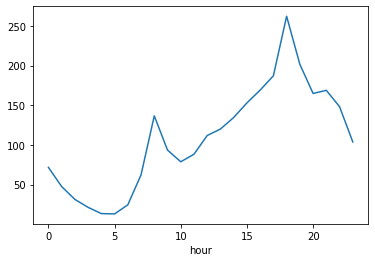

In [19]:
train.groupby('hour').mean()['count'].plot()

그래프를 보면 출퇴근, 등교 하교시간에 사용량이 많아지며 오후로 갈수록 사용량이 많아지는 것을 볼수 있음

In [20]:
import matplotlib.pyplot as plt

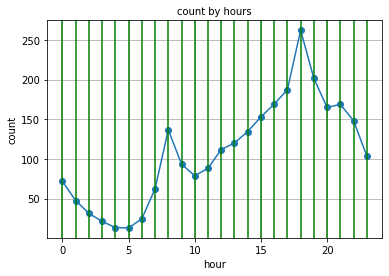

In [21]:
plt.plot(train.groupby('hour').mean()['count'], 'o-')
plt.grid()
plt.title('count by hours',fontsize = 10)
plt.xlabel('hour')
plt.ylabel('count') #plt.savefig('파일명.확장자')로 그래프 저장
for i in range(0,24):
  plt.axvline(x = i, color = 'green', linestyle = '-')

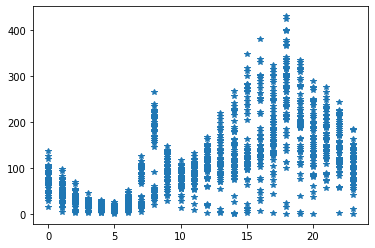

In [22]:
plt.plot('hour', 'count', '*', data = train)

In [23]:
import seaborn as sb

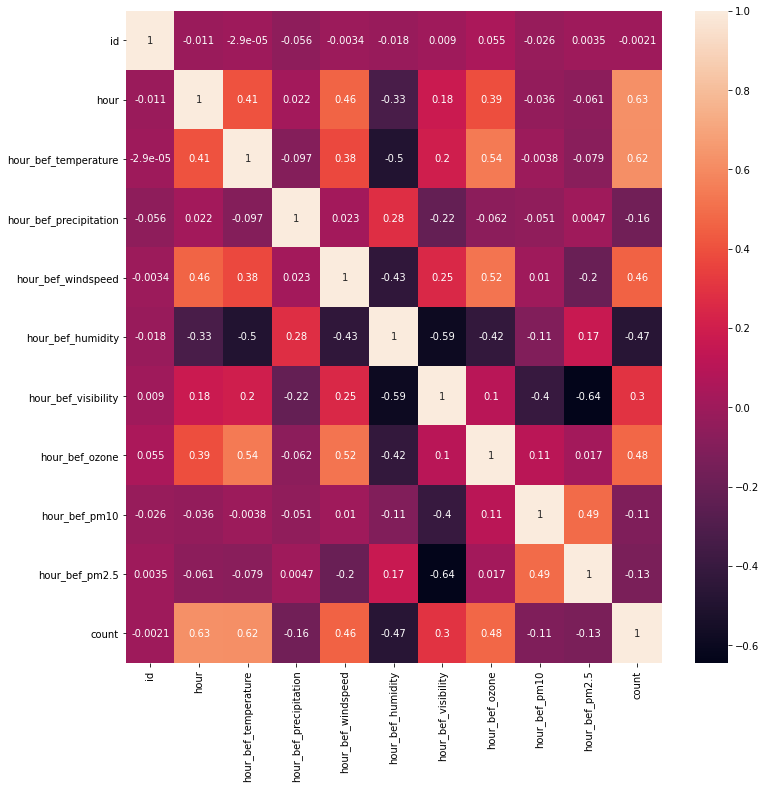

In [24]:
plt.figure(figsize= (12,12))
sb.heatmap(train.corr(), annot = True)

위의 히트 맵에서 상관 관계가 0.45 이상이면 관계성이 있다고 생각<br>
그러면 시간대, 1시간전 온도, 풍속, 오존농도, 습도와 관련이 있다.

## **데이터 전처리**

In [26]:
train.isna().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

결측치를 매워 줘야함

In [29]:
train[train['hour_bef_temperature'].isna()] #결측위치 파악

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
934,1420,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1035,1553,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


결측 위치가 0시와 18시에 기상정보가 누락되어 있는데 기상정보는 시간과 매우 관련이 높으므로 관계를 반영해서 채워 줘야함.

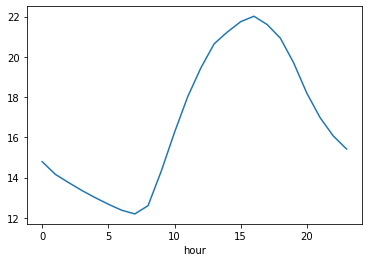

In [30]:
train.groupby('hour').mean()['hour_bef_temperature'].plot()


In [31]:
train.groupby('hour').mean()['hour_bef_temperature']

hour
0     14.788136
1     14.155738
2     13.747541
3     13.357377
4     13.001639
5     12.673770
6     12.377049
7     12.191803
8     12.600000
9     14.318033
10    16.242623
11    18.019672
12    19.457377
13    20.648333
14    21.234426
15    21.744262
16    22.015000
17    21.603333
18    20.926667
19    19.704918
20    18.191803
21    16.978333
22    16.063934
23    15.418033
Name: hour_bef_temperature, dtype: float64

In [35]:
train['hour_bef_temperature'].fillna({934:14.788136, 1035:20.926667}, inplace = True)
train.loc[[935,1035],:]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
935,1421,10,11.200000,0.0,1.5,58.0,1275.0,0.019,66.0,24.0,70.0
1035,1553,18,20.926667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
